In [ ]:
#!pip install --upgrade numpy
#!pip install --upgrade pandas
#!pip install --upgrade tensorflow
#!pip install --upgrade mediapipe opencv-python scipy

In [ ]:
#!pip install numpy==1.24.4 protobuf==3.20.3 thinc==8.1.0 grpcio-status==1.54.0 ydf==0.9.0

#!pip install mediapipe thinc grpcio-status ydf sounddevice

In [ ]:
!pip install mediapipe opencv-python matplotlib pandas scipy protobuf==3.20.3

In [ ]:
!pip uninstall protobuf
!pip install protobuf>=5.29.1,<6.0.0

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
from collections import deque

# If using Google Colab for file upload and image display
from google.colab import files
from google.colab.patches import cv2_imshow

In [266]:
# Upload video and calibration image
print("Upload your gait video:")
video_file = files.upload()
video_path = list(video_file.keys())[0]

Upload your gait video:


Saving gait_01.mov to gait_01 (1).mov


In [267]:
from google.colab import files
print("Upload your calibration image:")
calib_file = files.upload()
calib_image_path = list(calib_file.keys())[0]

Upload your calibration image:


Saving cal rec.png to cal rec (1).png


In [311]:
# 1. MANUAL INPUT: Four corners of the calibration rectangle in the image

pts_src = np.float32([
    [999,1353],   # top-left
    [1519,1449],   # top-right
    [942,1859],   # bottom-right
    [233,1655],   # bottom-left
])

# 2. Define the real-world rectangle corners (237 cm x 118 cm, in mm)
width_mm = 2370
height_mm = 1180
pts_dst = np.float32([
    [0, 0],                # top-left
    [width_mm, 0],         # top-right
    [width_mm, height_mm], # bottom-right
    [0, height_mm],        # bottom-left
])


In [312]:
# 3. Compute the homography matrix
calib_img = cv2.imread("/content/cal rec.png")

if calib_img is None:
    print(f"Error: Could not load image from path: {calib_image_path}")
else:
    H, status = cv2.findHomography(pts_src, pts_dst)
print("Homography matrix H:\n", H)

Homography matrix H:
 [[-3.53808002e+00 -8.97407052e+00  1.56764593e+04]
 [ 7.72186851e-01 -4.18267877e+00  4.88774972e+03]
 [ 8.50538968e-05 -1.56590140e-03  1.00000000e+00]]


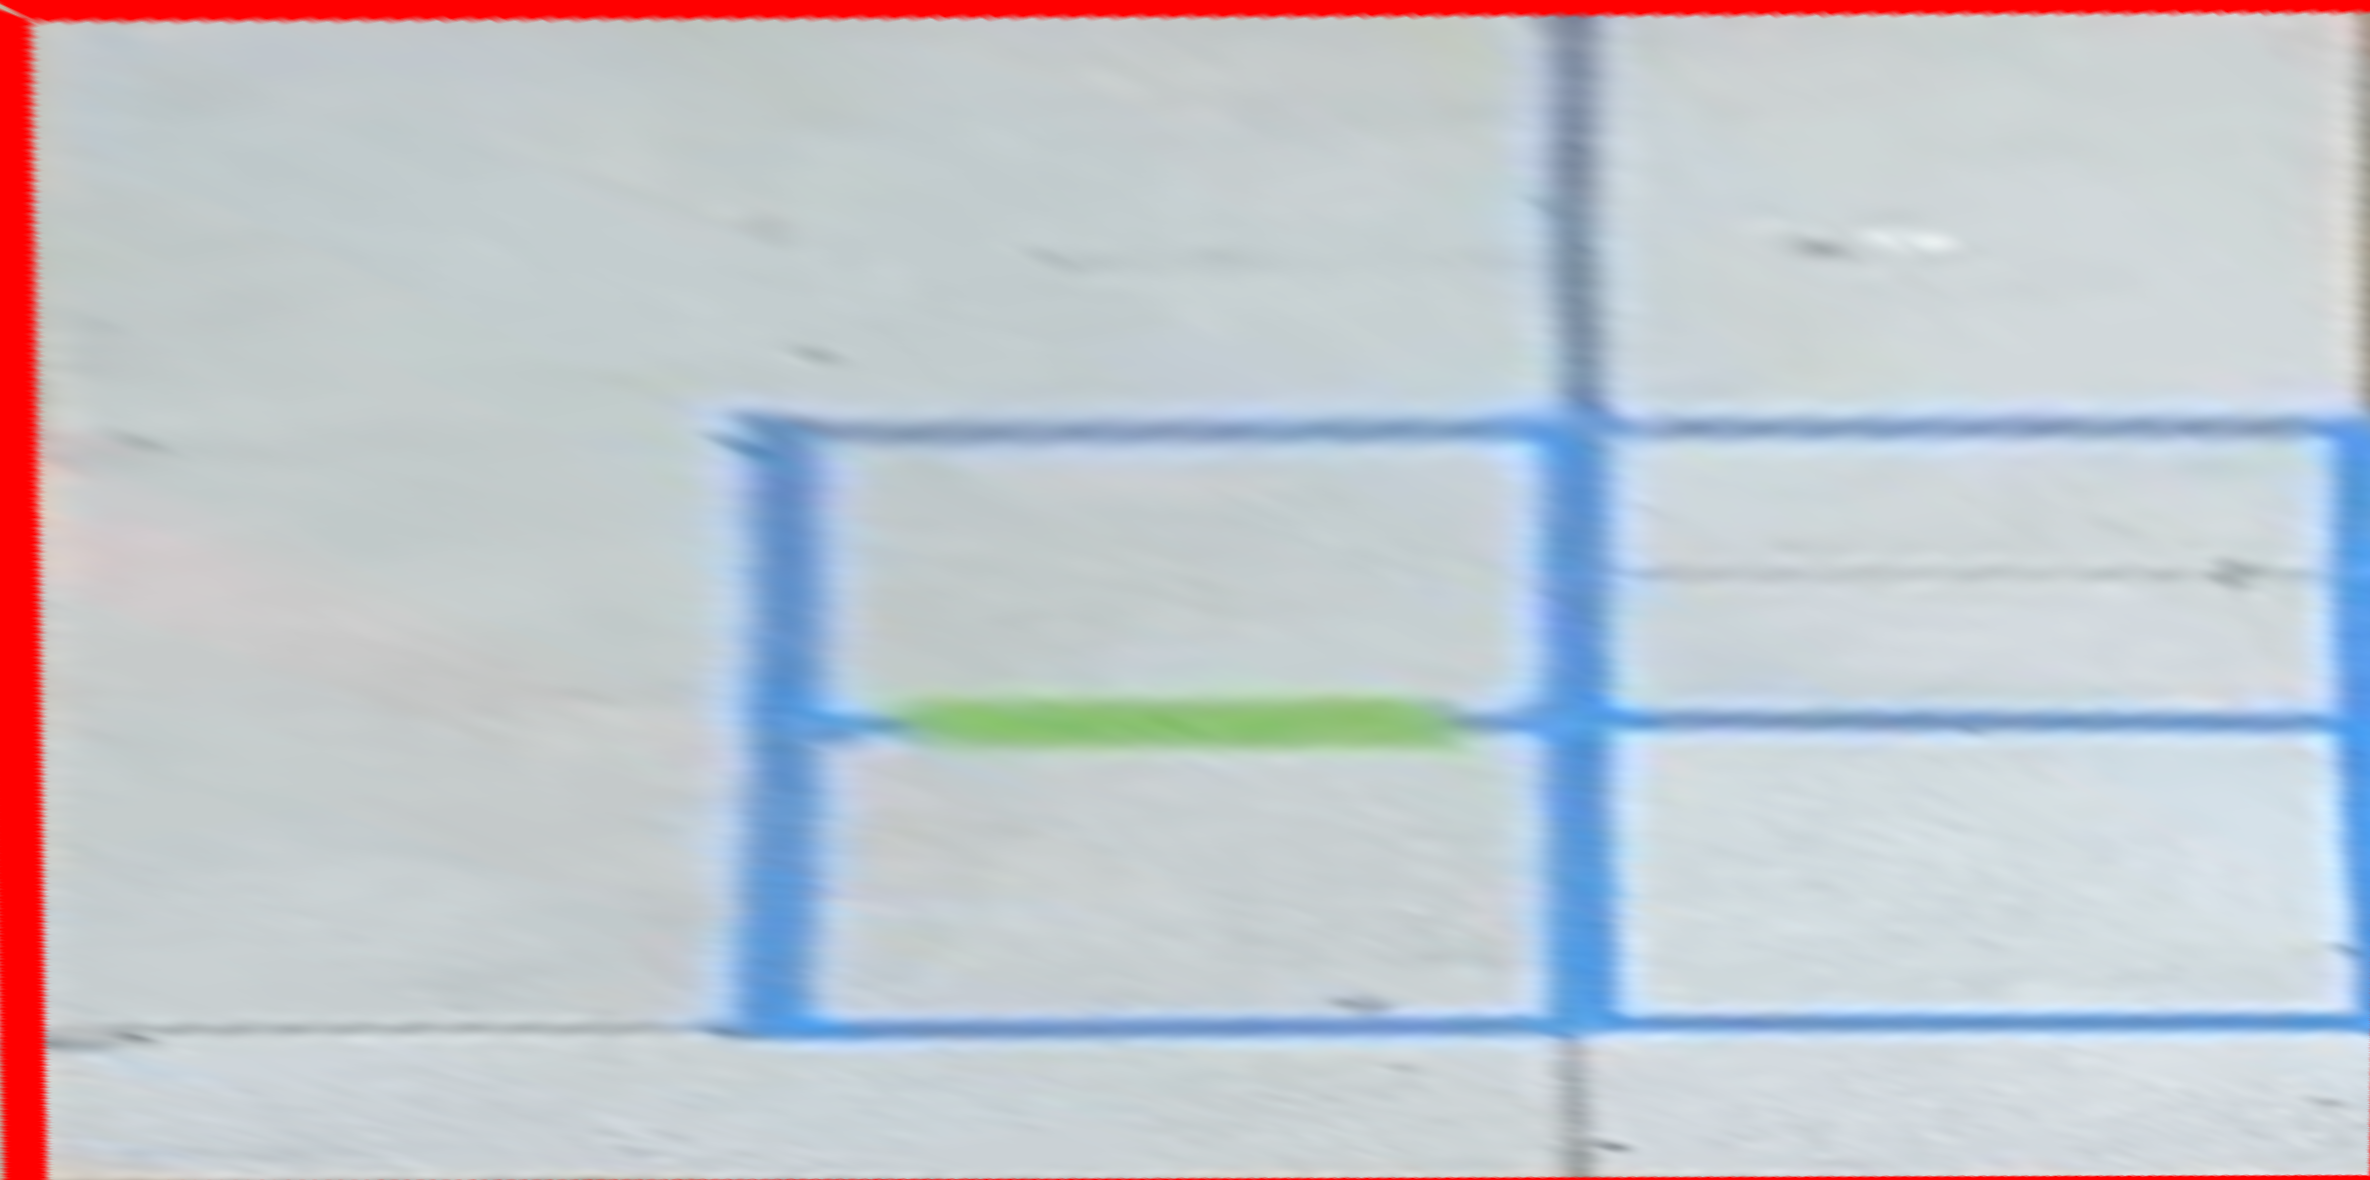

In [313]:
# 4. Warp the calibration image to verify rectification
warped = cv2.warpPerspective(calib_img, H, (width_mm, height_mm))
cv2_imshow(warped)

In [314]:
# Helper to warp points and convert to meters
def warp_points(points, H):
    if len(points) == 0:
        return np.array([])
    pts = np.array(points, dtype='float32').reshape(-1, 1, 2)
    warped_pts = cv2.perspectiveTransform(pts, H)  # Result in mm
    warped_pts = warped_pts.reshape(-1, 2)
    return warped_pts / 1000.0

In [315]:
# 6. Video and Pose Setup
video_path = '/content/gait_01.mov'
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"Frames per second (fps): {fps}")

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, enable_segmentation=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)
LEFT_HEEL = 29
RIGHT_HEEL = 30

heel_data = {'Left': [], 'Right': []}
timestamps = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    t_us = cap.get(cv2.CAP_PROP_POS_MSEC) * 1000
    img_h, img_w = frame.shape[:2]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb)

    if results.pose_landmarks:
        lms = results.pose_landmarks.landmark
        for foot, idx in [('Left', LEFT_HEEL), ('Right', RIGHT_HEEL)]:
            norm_x = lms[idx].x
            norm_y = lms[idx].y
            pixel_x = norm_x * img_w
            pixel_y = norm_y * img_h
            heel_data[foot].append((t_us/1e6, pixel_x, pixel_y))
    timestamps.append(t_us/1e6)

pose.close()
cap.release()

# Add this print statement
print(f"Left heel data points collected: {len(heel_data['Left'])}")
print(f"Right heel data points collected: {len(heel_data['Right'])}")


Frames per second (fps): 119.30531084822552
Left heel data points collected: 962
Right heel data points collected: 962


In [316]:
# 7. Low-pass filter for smoothing
def butter_filter(data, cutoff, fs, order, filter_type='low'):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    y = filtfilt(b, a, data)
    return y

fs = fps
cutoff = 3.0 #Hz

for foot in ['Left', 'Right']:
    arr = np.array(heel_data[foot])
    if len(arr) == 0:
        continue
    t = arr[:,0]
    x = arr[:,1]
    y = arr[:,2]
    x_filt = butter_lowpass_filter(x, cutoff, fs)
    y_filt = butter_lowpass_filter(y, cutoff, fs)
    heel_data[foot] = np.column_stack([t, x_filt, y_filt])


In [317]:
# 8. Transform heel points to rectified plane (in mm)
for foot in ['Left', 'Right']:
    arr = np.array(heel_data[foot])
    if len(arr) == 0:
        continue
    rectified = warp_points(arr[:,1:3], H)
    heel_data[foot] = np.column_stack([arr[:,0], rectified])  # t, x_mm, y_mm

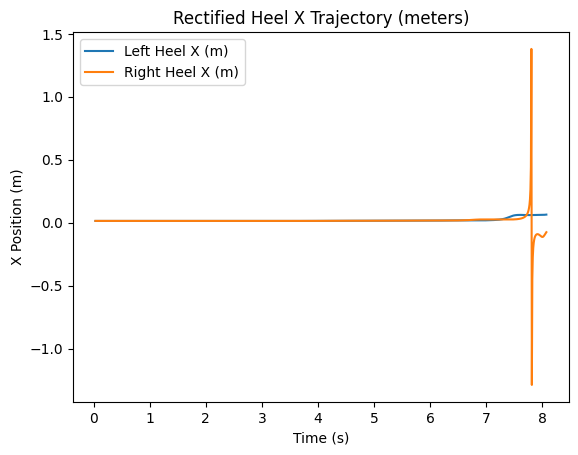

In [318]:
# 9. Plot rectified trajectories (in meters)
for foot in ['Left', 'Right']:
    arr = heel_data[foot]
    if len(arr) > 0:
        plt.plot(arr[:,0], arr[:,1]/1000, label=f'{foot} Heel X (m)')
plt.title('Rectified Heel X Trajectory (meters)')
plt.xlabel('Time (s)')
plt.ylabel('X Position (m)')
plt.legend()
plt.show()

In [319]:
import matplotlib.pyplot as plt

def visualize_warped_points(points):
    x, y = zip(*points)
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, 'ro-')
    plt.title("Warped Gait Trajectory (in meters)")
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.grid(True)
    plt.show()


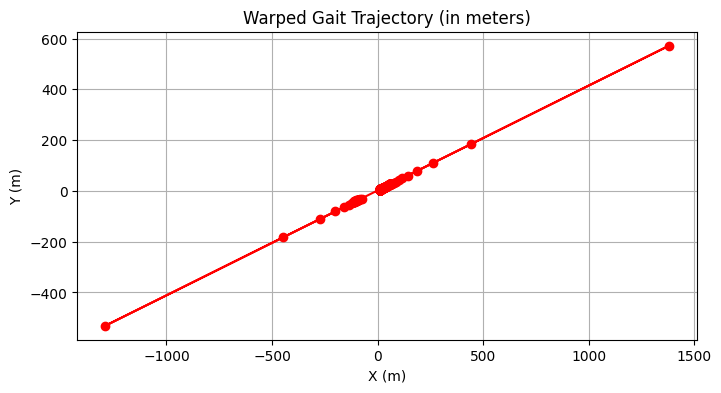

In [320]:
warped_positions = []
for foot in ['Left', 'Right']:
    arr = heel_data[foot]
    if len(arr) > 0:
        warped_positions.extend(arr[:, 1:3].tolist())

warped_positions = np.array(warped_positions)

visualize_warped_points(warped_positions)

In [321]:
# Define step_positions
step_positions = []
for foot in ['Left', 'Right']:
    step_positions.extend([pos[1:] for pos in heel_data[foot]])
step_positions = np.array(step_positions)


In [322]:
# 10. Event Detection (HS/TO) using y minima/maxima
events = []
window = 5

def is_local_min(y, i, w):
    return all(y[i] < y[j] for j in range(max(0, i-w), min(len(y), i+w+1)) if j != i)

def is_local_max(y, i, w):
    return all(y[i] > y[j] for j in range(max(0, i-w), min(len(y), i+w+1)) if j != i)

for foot in ['Left', 'Right']:
    arr = heel_data[foot]
    if len(arr) < window:
        if len(arr) > 0:
            print(f"Warning: Not enough data points ({len(arr)}) for {foot} foot to perform event detection (window size: {window}).")
        continue

    t = arr[:, 0]
    x = arr[:, 1] / 1000.0
    y = arr[:, 2] / 1000.0

    if len(y) >= 2 * window + 1:
        for i in range(window, len(y) - window):
            if is_local_min(y, i, window):
                events.append({'event': 'HS', 'foot': foot, 't': t[i], 'x': x[i], 'y': y[i]})
            if is_local_max(y, i, window):
                events.append({'event': 'TO', 'foot': foot, 't': t[i], 'x': x[i], 'y': y[i]})
    else:
        print(f"Warning: Data for {foot} foot is too short ({len(y)} points) for the chosen window size ({window}). Skipping event detection for this foot.")


df = pd.DataFrame(events)
metrics = {}

if df.empty:
    print("\n=== Gait Metrics (Perspective-Corrected) ===")
    print("No events detected. Cannot compute gait metrics.")
else:
# 11. Metric Extraction

    # Cycle Time (seconds)
    for foot in ['Left', 'Right']:
        hs_times = df[(df['foot'] == foot) & (df['event'] == 'HS')]['t'].values
        if len(hs_times) >= 2:
            cycle_times = np.diff(hs_times)
            metrics[f'Cycle Time ({foot})'] = np.mean(cycle_times)

    # Step Length (meters) using nearest-opposite HS
    step_lengths = []
    for index, row in df[df['event'] == 'HS'].iterrows():
        opposite_foot = 'Left' if row['foot'] == 'Right' else 'Right'
        opp_hs = df[(df['foot'] == opposite_foot) & (df['event'] == 'HS')]
        if len(opp_hs) == 0:
            continue
        time_diffs = np.abs(opp_hs['t'].values - row['t'])
        nearest_idx = np.argmin(time_diffs)
        nearest = opp_hs.iloc[nearest_idx]
        dist = np.sqrt((row['x'] - nearest['x'])**2 + (row['y'] - nearest['y'])**2)
        step_lengths.append(dist)
    if step_lengths:
        metrics['Average Step Length (m)'] = np.mean(step_lengths)

    # Stride Length (meters)
    stride_lengths = []
    for foot in ['Left', 'Right']:
        hs_foot = df[(df['foot'] == foot) & (df['event'] == 'HS')]
        for i in range(len(hs_foot) - 1):
            x1, y1 = hs_foot.iloc[i][['x', 'y']]
            x2, y2 = hs_foot.iloc[i+1][['x', 'y']]
            dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            stride_lengths.append(dist)
    if stride_lengths:
        metrics['Average Stride Length (m)'] = np.mean(stride_lengths)

    # Gait Speed (meters/second)
    avg_cycle_time = 0
    if 'Cycle Time (Left)' in metrics and 'Cycle Time (Right)' in metrics:
        avg_cycle_time = (metrics['Cycle Time (Left)'] + metrics['Cycle Time (Right)']) / 2
    elif 'Cycle Time (Left)' in metrics:
         avg_cycle_time = metrics['Cycle Time (Left)']
    elif 'Cycle Time (Right)' in metrics:
         avg_cycle_time = metrics['Cycle Time (Right)']

    if metrics.get('Average Stride Length (m)', 0) > 0 and avg_cycle_time > 0:
         metrics['Gait Speed (m/s)'] = metrics['Average Stride Length (m)'] / avg_cycle_time


    # Stance Time (seconds)
    for foot in ['Left', 'Right']:
        to_times = df[(df['foot'] == foot) & (df['event'] == 'TO')]['t'].values
        hs_times = df[(df['foot'] == foot) & (df['event'] == 'HS')]['t'].values
        stance_times = []
        for to in to_times:
            next_hs = hs_times[hs_times > to]
            if len(next_hs) > 0:
                stance_times.append(next_hs[0] - to)
        if stance_times:
            metrics[f'Stance Time ({foot})'] = np.mean(stance_times)

    # Double Support Time (seconds)
    ds_times = []
    df_sorted = df.sort_values(by='t').reset_index(drop=True)

    for i in range(len(df_sorted) - 1):
        event1 = df_sorted.iloc[i]
        event2 = df_sorted.iloc[i+1]

        if (event1['event'] == 'TO' and event2['event'] == 'HS' and event1['foot'] != event2['foot']):
             ds_times.append(event2['t'] - event1['t'])

    if ds_times:
        metrics['Average Double Support Time (s)'] = np.mean(ds_times)
    else:
         print("Warning: Could not calculate Double Support Time. Check event detection.")


    # Step Width (meters)
    widths = []
    hs_events = df[df['event'] == 'HS'].sort_values(by='t').reset_index(drop=True)

    for i in range(len(hs_events)):
        current_hs = hs_events.iloc[i]
        opposite_foot = 'Left' if current_hs['foot'] == 'Right' else 'Right'

        subsequent_opp_hs = hs_events[(hs_events['foot'] == opposite_foot) & (hs_events['t'] > current_hs['t'])]

        if not subsequent_opp_hs.empty:
            nearest_subsequent_idx = np.argmin(np.abs(subsequent_opp_hs['t'].values - current_hs['t']))
            nearest_subsequent = subsequent_opp_hs.iloc[nearest_subsequent_idx]
            width = abs(current_hs['x'] - nearest_subsequent['x'])
            widths.append(width)
        else:
            previous_opp_hs = hs_events[(hs_events['foot'] == opposite_foot) & (hs_events['t'] < current_hs['t'])]
            if not previous_opp_hs.empty:
                 nearest_previous_idx = np.argmin(np.abs(previous_opp_hs['t'].values - current_hs['t']))
                 nearest_previous = previous_opp_hs.iloc[nearest_previous_idx]
                 width = abs(current_hs['x'] - nearest_previous['x'])
                 widths.append(width)


    if widths:
        metrics['Average Step Width (m)'] = np.mean(widths)
    else:
         print("Warning: Could not calculate Step Width. Check event detection.")

    print("Step Positions Before Calibration:", step_positions)
    print("Step Positions After Calibration:", warped_positions)

    # === 12. Display Metrics ===
    print("\n=== Gait Metrics (Perspective-Corrected) ===")
    for k, v in metrics.items():
        print(f"{k}: {v:.3f}")


Step Positions Before Calibration: [[ 13.28757095   5.279459  ]
 [ 13.28010464   5.28044987]
 [ 13.27279282   5.28142595]
 ...
 [-87.0477829  -34.76344681]
 [-81.31518555 -32.58553314]
 [-76.13247681 -30.5943718 ]]
Step Positions After Calibration: [[ 13.28757095   5.279459  ]
 [ 13.28010464   5.28044987]
 [ 13.27279282   5.28142595]
 ...
 [-87.0477829  -34.76344681]
 [-81.31518555 -32.58553314]
 [-76.13247681 -30.5943718 ]]

=== Gait Metrics (Perspective-Corrected) ===
Cycle Time (Left): 0.636
Cycle Time (Right): 0.655
Average Step Length (m): 0.135
Average Stride Length (m): 0.120
Gait Speed (m/s): 0.186
Stance Time (Left): 0.205
Stance Time (Right): 0.225
Average Double Support Time (s): 0.067
Average Step Width (m): 0.126


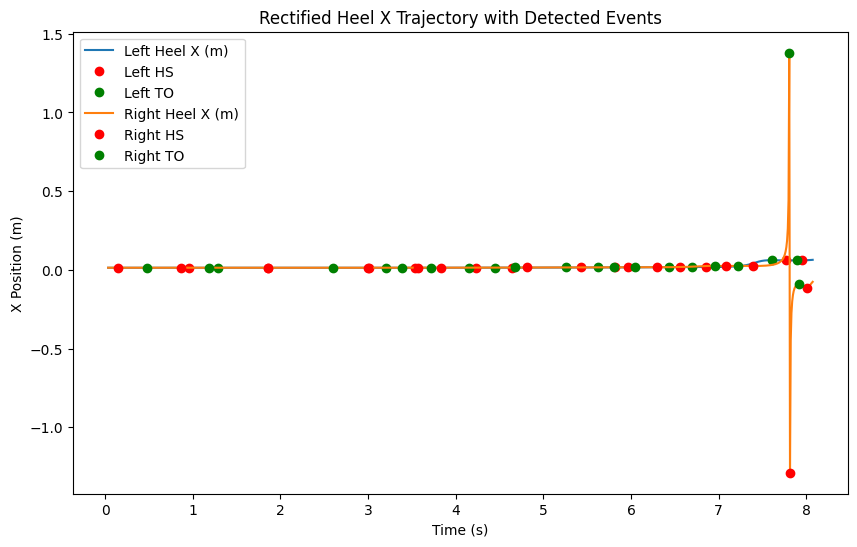

In [323]:
if not df.empty:
    plt.figure(figsize=(10, 6))
    for foot in ['Left', 'Right']:
        # Ensure arr is a numpy array
        arr = np.array(heel_data[foot])
        if len(arr) > 0:
            # Now slicing with arr[:,0] and arr[:,1] will work
            plt.plot(arr[:,0], arr[:,1]/1000, label=f'{foot} Heel X (m)')

        # Plot detected events
        hs_events = df[(df['foot'] == foot) & (df['event'] == 'HS')]
        to_events = df[(df['foot'] == foot) & (df['event'] == 'TO')]
        plt.plot(hs_events['t'], hs_events['x'], 'ro', label=f'{foot} HS') # Red circles for HS
        plt.plot(to_events['t'], to_events['x'], 'go', label=f'{foot} TO') # Green circles for TO

    plt.title('Rectified Heel X Trajectory with Detected Events')
    plt.xlabel('Time (s)')
    plt.ylabel('X Position (m)')
    plt.legend()
    plt.show()